# Models Testing

In [1]:
from imports import *
import pipeline_functions as pipeline_functions
%matplotlib inline

In [2]:
df_shapes_log = pd.DataFrame()

## Import datasets processed in previous step

In [3]:
df=pd.read_hdf(config.df_features_selections, 'df')
df_test=pd.read_hdf(config.df_test_features_selections, 'df')

In [4]:
df_shapes_log = pd.concat([df_shapes_log, fn.df_shape(X = df, Y = df[config.y_column],description= 'cleaned dataset')])
df_shapes_log = pd.concat([df_shapes_log, fn.df_shape(X = df_test, Y = df_test[config.y_column],description= 'cleaned test dataset')])
df_shapes_log


,Description,X_Cols,X_Rows,Y_Rows,Y0,Y1,Y1 %
0,cleaned dataset,21,1687860,1687860,1676567,11293,0.67
0,cleaned test dataset,21,242075,242075,239387,2688,1.11


## Define functions that will help the models evaluations

In [5]:
def ModelsGridSearch(label: str, scorings, calibrate_classifier:bool, models_to_test, X_train_, y_train_, X_test_, y_test_):
     for model in models_to_test:
        print('==== Starting:', label + " - " + model['label'], '====')
        begin = time.perf_counter()
        for scoring in scorings:
            scoring_name= 'MCC' if callable(scoring) else scoring
            print('==== Starting:', label + " - " + model['label'], '==== SCORING ' + scoring_name)
            try:
                ModelEvaluation(
                    label = label + ' - ' + model['label'] + ' scoring=' + scoring_name,
                    scoring=scoring,
                    calibrate_classifier=calibrate_classifier,
                    base_estimator = model['classifier'],
                    params = model['params'],
                    X_train_ =  X_train_,
                    y_train_ = y_train_,
                    X_test_ = X_test_,
                    y_test_ = y_test_,
                    k_folds_splits = model['k_folds_splits'],

                )
            except Exception as e:
                error = e
                print("**** ERROR ****")
                print(e)
            print('==== Ended:', label + " - " + model['label'], '==== SCORING ' + scoring_name)
        end = time.perf_counter()
        print('==== Ended:', label + " - " + model['label'], '==== Time:',round(end - begin,3))


def ModelEvaluation(label: str, scoring, base_estimator : object, params: object, X_train_, y_train_, X_test_, y_test_, calibrate_classifier : bool = False, k_folds_splits = 3):

    with warnings.catch_warnings():
        warnings.simplefilter('ignore',UserWarning)
        warnings.simplefilter('ignore',FutureWarning)
        warnings.filterwarnings('ignore')

        if calibrate_classifier:
            estimator = CalibratedClassifierCV(base_estimator=base_estimator, method="sigmoid", n_jobs=4),
            final_params = { k.replace('classifier__', 'classifier__base_estimator__'): v for k, v in params.items() }
        else:
            estimator = base_estimator
            final_params = params

        pipeline = imbpipeline(steps = [
            ['missing_values', SimpleImputer(strategy='median')],
            # ['missing_values', KNNImputer(n_neighbors=2)],
            ['outliers', pipeline_functions.OutliersProcessing()],
            ['scaler', pipeline_functions.CustomScaler()],
            # ['pca', PCA()],
            ['resample', pipeline_functions.ImbalancedDataSampling()],
            ['classifier', estimator]
        ])     
    
        stratified_kfold = StratifiedKFold(n_splits=k_folds_splits, shuffle=True, random_state=config.proj_random_state)

        grid_search = HalvingGridSearchCV(
            estimator=pipeline,
            param_grid=final_params,
            scoring=scoring,
            return_train_score=True,
            cv=stratified_kfold,
            refit=True,
            n_jobs=4,
            random_state=config.proj_random_state,
            verbose=0
        )
    
        grid_search.fit(X_train_, y_train_)
        
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test_, y_test_)

    print("================",label,"================")
    print('Best parameters:', grid_search.best_params_)
    print('Train Score:', cv_score)
    print('Test Score:', test_score)

    pipeline_functions.plot_curves_and_scores(
        title= label, 
        classifier=grid_search.best_estimator_,
        train=X_train_,
        test=X_test_,
        y_train=y_train_,
        y_test=y_test_
    )

    warnings.resetwarnings()
  

## Function that constructs the tests configuration file with models and parameters to evaluate with grid search

In [6]:

def models_to_test(scaler_strategy: pipeline_functions.CustomScalerType, pca_components: int, k_folds_splits : int = 3):

    ressample_strategies = [
        pipeline_functions.InbalancedDataSamplingStrategy.NONE,
        pipeline_functions.InbalancedDataSamplingStrategy.SMOTE,
        pipeline_functions.InbalancedDataSamplingStrategy.NEARMISS,
        pipeline_functions.InbalancedDataSamplingStrategy.ADASYN
    ]

    return [
        {
            'label': 'XGBoost',
            'k_folds_splits': k_folds_splits,
            'classifier': xgb.XGBClassifier(random_state=config.proj_random_state,use_label_encoder=False),
            'params':  {
                #'resample__strategy': ressample_strategies,
                'resample__strategy': [pipeline_functions.InbalancedDataSamplingStrategy.SMOTE],
                # 'classifier__eval_metric': [ 'logloss', 'aucpr'],
                'classifier__eval_metric': [ 'logloss' ],  
                # 'outliers__strategy': [pipeline_functions.OutliersProcessingStrategy.CLIP, pipeline_functions.OutliersProcessingStrategy.NONE],
                'outliers__strategy': [pipeline_functions.OutliersProcessingStrategy.CLIP],
                # 'objective': ['binary:logistic']
                #'pca__n_components': [pca_components],
                # 'classifier__learning_rate':[0.001,0.01,0.1, 1],
                'classifier__learning_rate':[0.1],         
                # 'classifier__auto_class_weights' : ["Balanced", "SqrtBalanced", None],
            }
        }
    ]

    return [
        {
            'label': 'XGBoost',
            'k_folds_splits': k_folds_splits,
            'classifier': xgb.XGBClassifier(random_state=config.proj_random_state,use_label_encoder=False),
            'params':  {
                'resample__strategy': ressample_strategies,
                 'classifier__eval_metric': [ 'logloss', 'aucpr'],
                 'outliers__strategy': [pipeline_functions.OutliersProcessingStrategy.CLIP, pipeline_functions.OutliersProcessingStrategy.NONE],
                 'objective': ['binary:logistic'],
                'pca__n_components': [pca_components],
                 'classifier__learning_rate':[0.001,0.01,0.1, 1],
                 'classifier__auto_class_weights' : ["Balanced", "SqrtBalanced", None],
            }
        },
        {
            'label': 'RandomForestClassifier',
            'k_folds_splits': k_folds_splits,
            'classifier': RandomForestClassifier(random_state=config.proj_random_state),
            'params':  {
                'resample__strategy': ressample_strategies,
                'scaler__strategy': [scaler_strategy],
                'pca__n_components': [pca_components],
                 'classifier__class_weight' : ["balanced", "balanced_subsample", None],
                'classifier__n_estimators':[10,20,30,50],
                'classifier__min_samples_leaf':[1,2,3],
                'classifier__min_samples_split':[3,4,5,6,7],
                'classifier__max_depth':[None,3,5,7],
            }
        },
        {
            'label': 'LogisticRegression',
            'k_folds_splits': k_folds_splits,
            'classifier': LogisticRegression(random_state=config.proj_random_state),
            'params':  {
                'resample__strategy': [ressample_strategies],
                'scaler__strategy': [scaler_strategy],
                'pca__n_components': [pca_components],
                "classifier__C": [10 ** lam for lam in range(-5,4)],
                "classifier__penalty": ["l2"],
                "classifier__fit_intercept": [True, False],
                'classifier__class_weight' : ["balanced", None],
            }
        },
        {
            'label': 'GaussianNB',
            'k_folds_splits': k_folds_splits,
            'classifier': GaussianNB(),
            'params':  {
                'resample__strategy': ressample_strategies,
                'scaler__strategy': [scaler_strategy],
                'pca__n_components': [pca_components],
                'classifier__var_smoothing':[0.00001,0.0002, 0.0001, 0.001, 0.01, 0.1,0.2,0.5],
            }
        },
        {
            'label': 'CATBoost',
            'k_folds_splits': k_folds_splits,
            'classifier': CatBoostClassifier(random_state=config.proj_random_state, logging_level='Silent'),
            'params':  {
                'resample__strategy': ressample_strategies,
                'scaler__strategy': [scaler_strategy],
                'pca__n_components': [pca_components],
                'classifier__learning_rate':[0.001,0.01,0.1, 1],
                'classifier__auto_class_weights' : ["Balanced", "SqrtBalanced", None],
            }
        }
   ]




## Prepares data and starts models evaluation

In [7]:
X = df.drop(columns=[config.y_column])
y = df[config.y_column]

X_test = df_test.drop(columns=[config.y_column])
y_test = df_test[config.y_column]

==== Starting: Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost ====
==== Starting: Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost ==== SCORING f1
================ Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 ================
Best parameters: {'classifier__eval_metric': 'logloss', 'classifier__learning_rate': 0.1, 'outliers__strategy': <OutliersProcessingStrategy.CLIP: 2>, 'resample__strategy': <InbalancedDataSamplingStrategy.SMOTE: 2>}
Train Score: 0.1497331909331411
Test Score: 0.20537405303030304


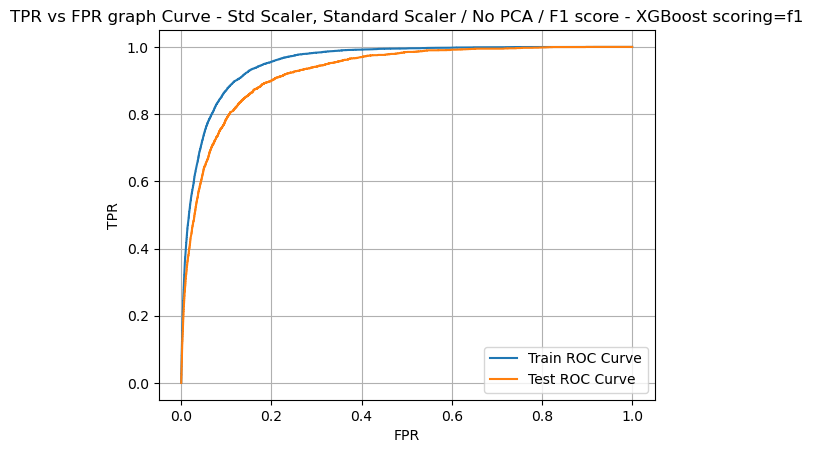

Train AUC Score 0.9547052947889801
Test AUC Score 0.9266965466495575
0.5


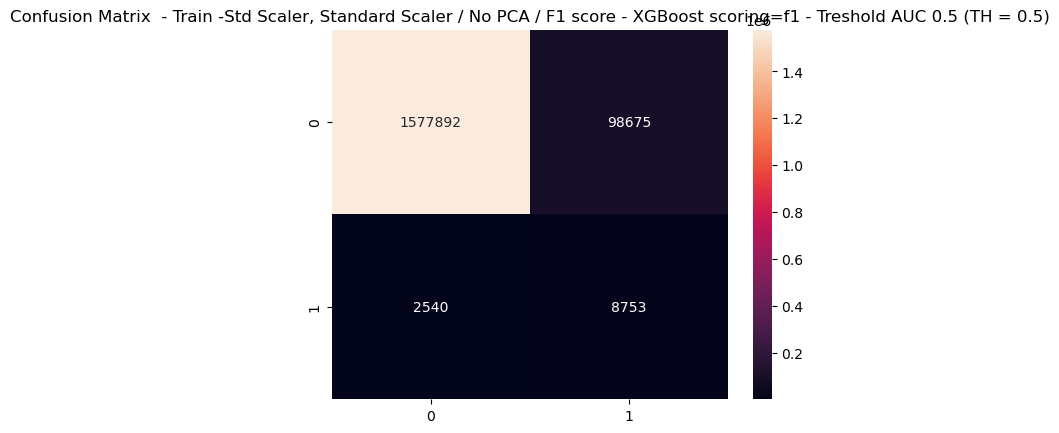

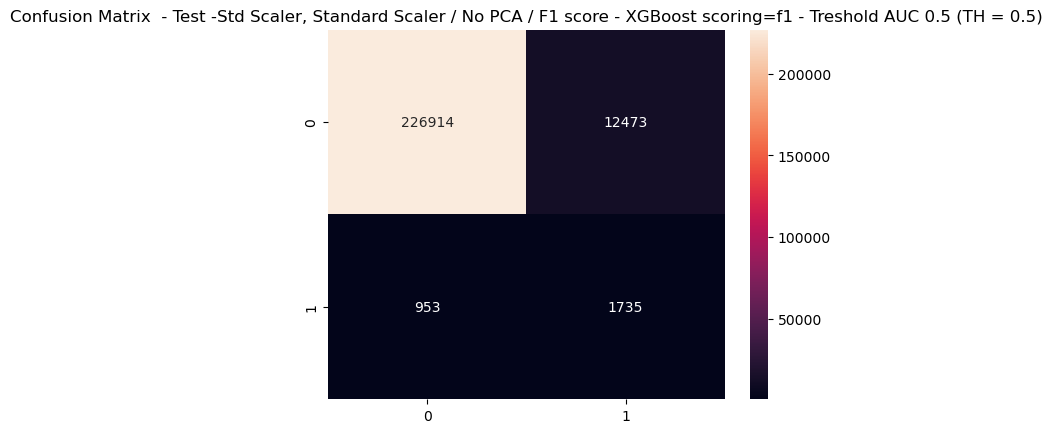



Train - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold AUC 0.5 (TH = 0.5)
F1-score: 0.14745495742118073 F1-score-micro: 0.9400335335869089 MCC: 0.23917669880272155
              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1676567
           1       0.08      0.78      0.15     11293

    accuracy                           0.94   1687860
   macro avg       0.54      0.86      0.56   1687860
weighted avg       0.99      0.94      0.96   1687860


Test - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold AUC 0.5 (TH = 0.5)
F1-score: 0.20537405303030304 F1-score-micro: 0.9445378498399256 MCC: 0.26452948135106263
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    239387
           1       0.12      0.65      0.21      2688

    accuracy                           0.94    242075
   macro avg       0.56      0.80      0.59    242075
weigh

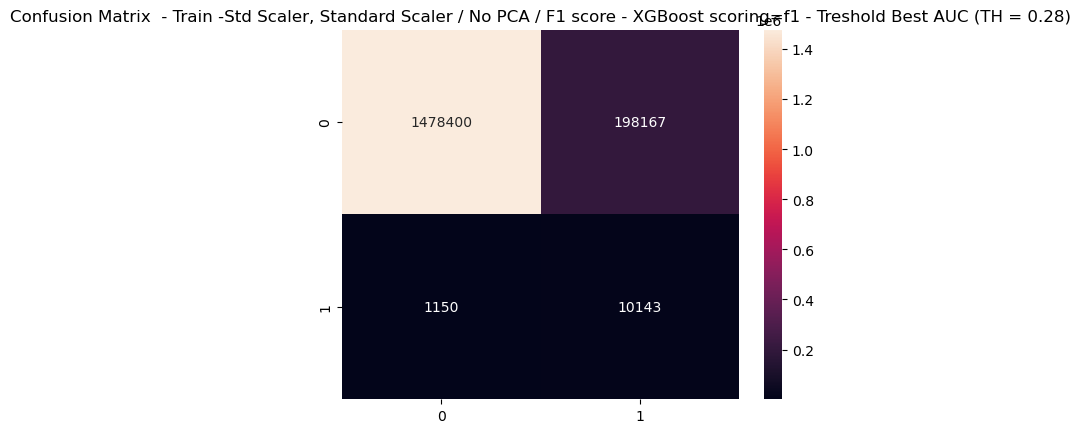

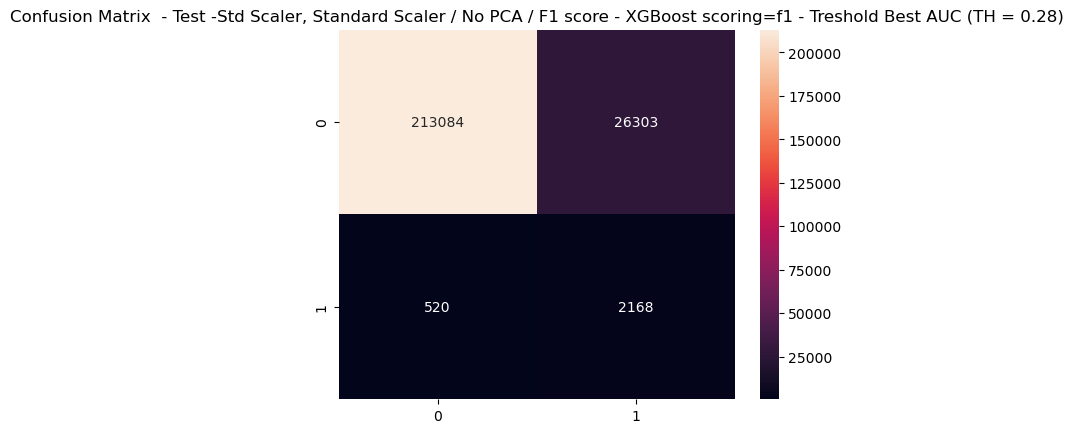



Train - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC (TH = 0.28)
F1-score: 0.09237578721602163 F1-score-micro: 0.8819114144538054 MCC: 0.19331810939552935
              precision    recall  f1-score   support

           0       1.00      0.88      0.94   1676567
           1       0.05      0.90      0.09     11293

    accuracy                           0.88   1687860
   macro avg       0.52      0.89      0.51   1687860
weighted avg       0.99      0.88      0.93   1687860


Test - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC (TH = 0.28)
F1-score: 0.13915722584165088 F1-score-micro: 0.889195497263245 MCC: 0.22661397244503148
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    239387
           1       0.08      0.81      0.14      2688

    accuracy                           0.89    242075
   macro avg       0.54      0.85      0.54    242075
we

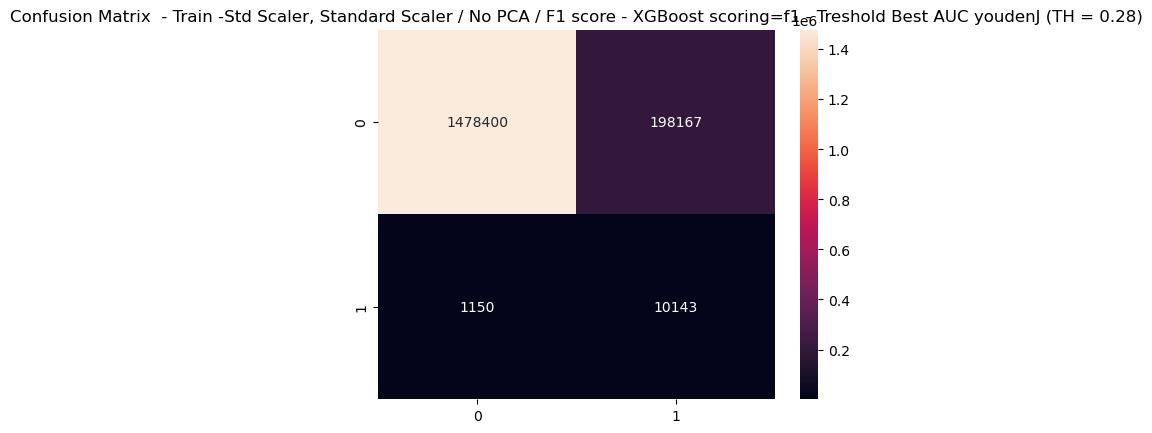

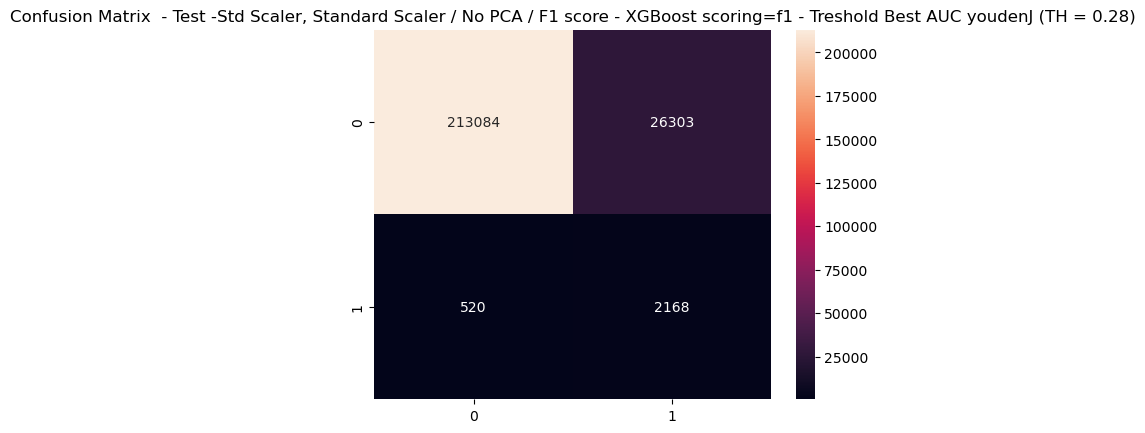



Train - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC youdenJ (TH = 0.28)
F1-score: 0.09237578721602163 F1-score-micro: 0.8819114144538054 MCC: 0.19331810939552935
              precision    recall  f1-score   support

           0       1.00      0.88      0.94   1676567
           1       0.05      0.90      0.09     11293

    accuracy                           0.88   1687860
   macro avg       0.52      0.89      0.51   1687860
weighted avg       0.99      0.88      0.93   1687860


Test - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC youdenJ (TH = 0.28)
F1-score: 0.13915722584165088 F1-score-micro: 0.889195497263245 MCC: 0.22661397244503148
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    239387
           1       0.08      0.81      0.14      2688

    accuracy                           0.89    242075
   macro avg       0.54      0.85      0

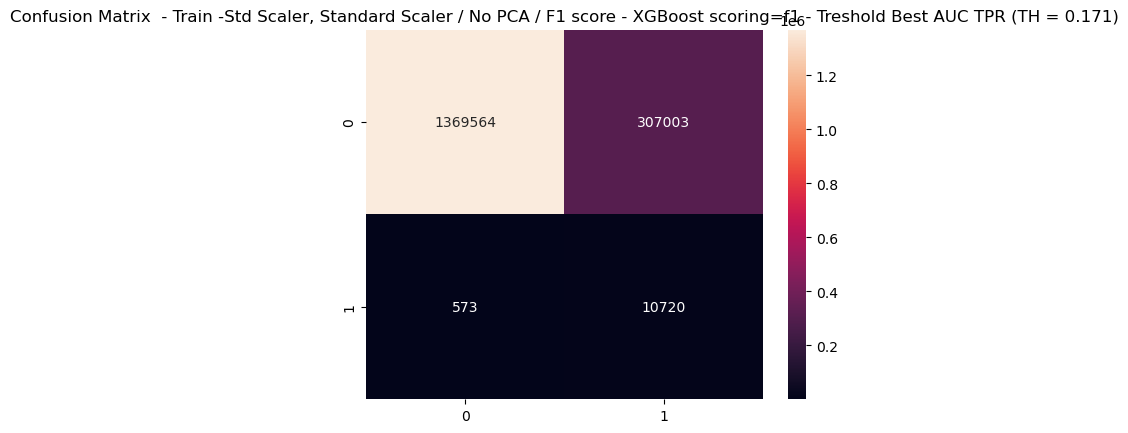

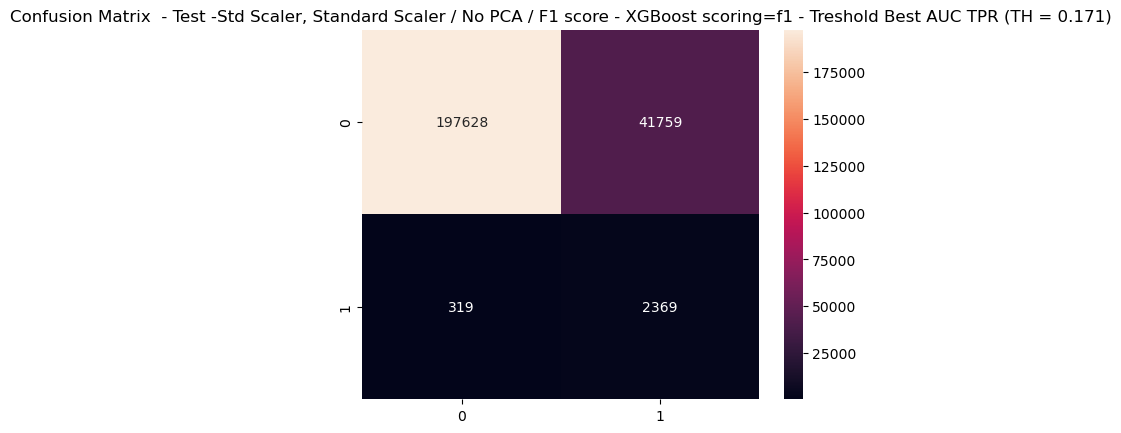



Train - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC TPR (TH = 0.171)
F1-score: 0.06516400418216743 F1-score-micro: 0.8177716161292998 MCC: 0.15977934626113258
              precision    recall  f1-score   support

           0       1.00      0.82      0.90   1676567
           1       0.03      0.95      0.07     11293

    accuracy                           0.82   1687860
   macro avg       0.52      0.88      0.48   1687860
weighted avg       0.99      0.82      0.89   1687860


Test - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC TPR (TH = 0.171)
F1-score: 0.10120471633629528 F1-score-micro: 0.8261778374470722 MCC: 0.19185842634833697
              precision    recall  f1-score   support

           0       1.00      0.83      0.90    239387
           1       0.05      0.88      0.10      2688

    accuracy                           0.83    242075
   macro avg       0.53      0.85      0.50  

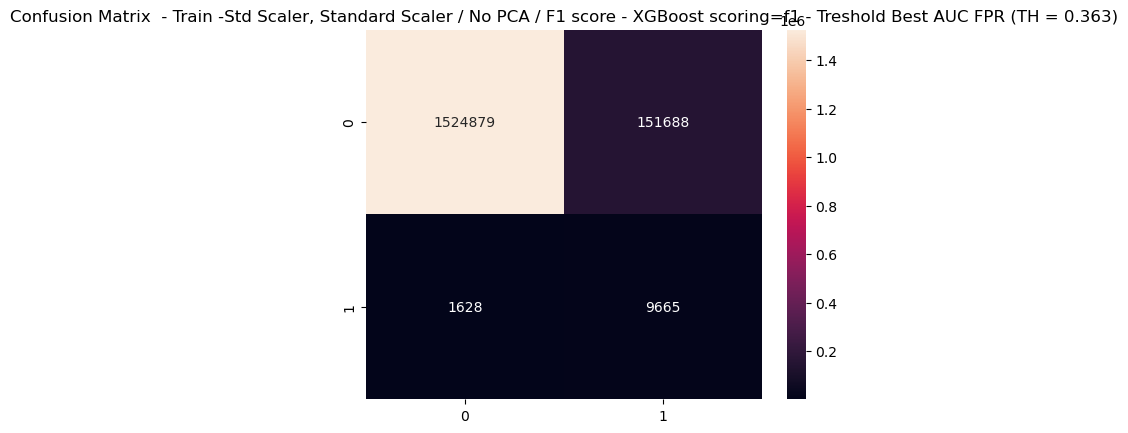

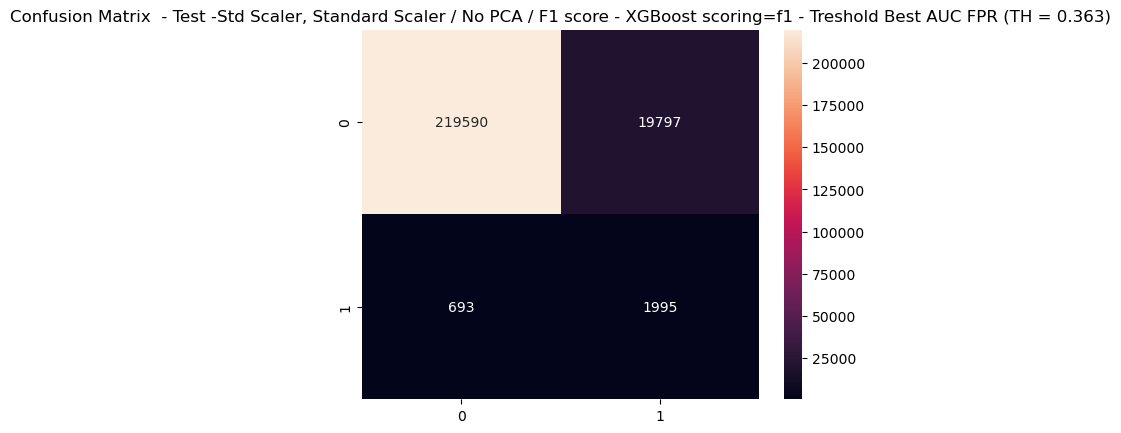



Train - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC FPR (TH = 0.363)
F1-score: 0.11196320795153088 F1-score-micro: 0.9091654521109571 MCC: 0.2122000769750222
              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1676567
           1       0.06      0.86      0.11     11293

    accuracy                           0.91   1687860
   macro avg       0.53      0.88      0.53   1687860
weighted avg       0.99      0.91      0.95   1687860


Test - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best AUC FPR (TH = 0.363)
F1-score: 0.16299019607843138 F1-score-micro: 0.9153568109057111 MCC: 0.24145337706410755
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    239387
           1       0.09      0.74      0.16      2688

    accuracy                           0.92    242075
   macro avg       0.54      0.83      0.56   

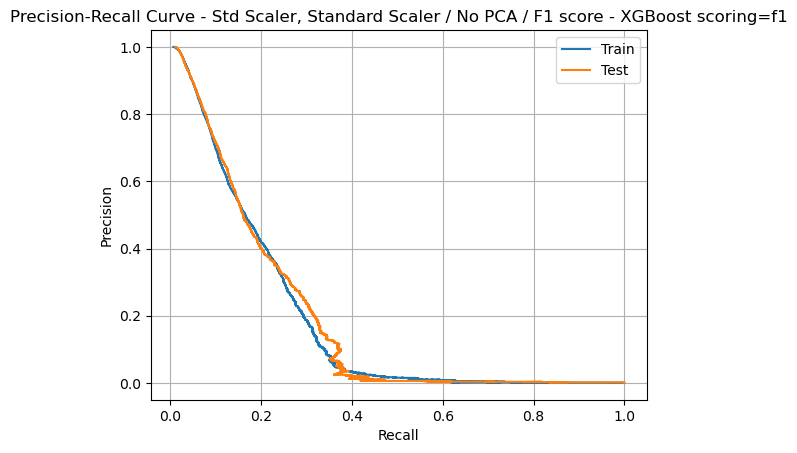

Train average precision Score 0.18576914732997982
Test average precision Score 0.18576914732997982
0.5


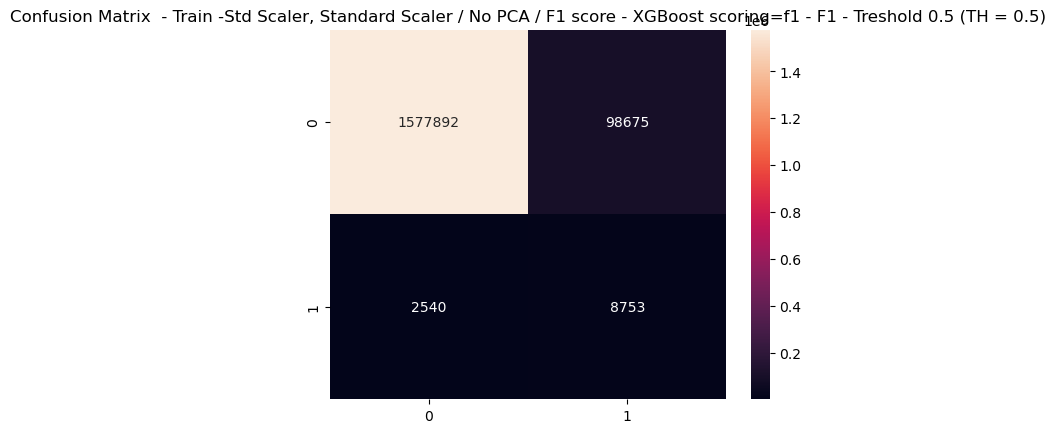

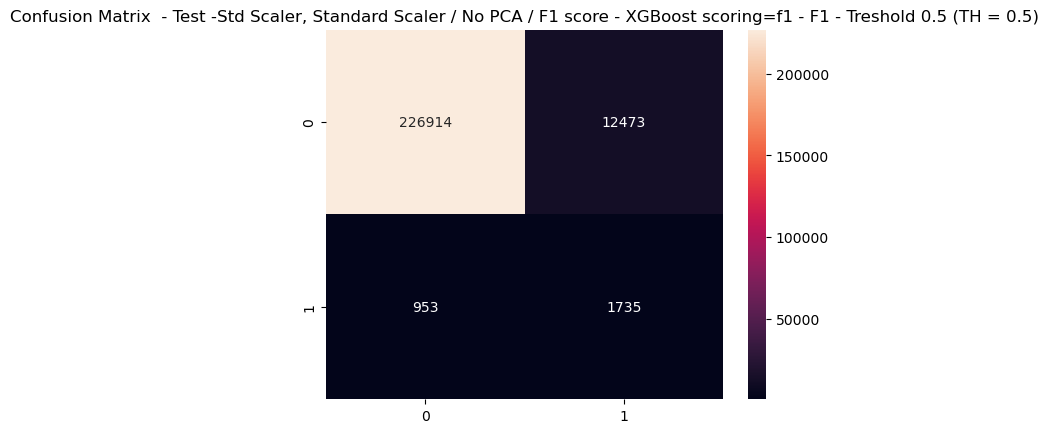



Train - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - F1 - Treshold 0.5 (TH = 0.5)
F1-score: 0.14745495742118073 F1-score-micro: 0.9400335335869089 MCC: 0.23917669880272155
              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1676567
           1       0.08      0.78      0.15     11293

    accuracy                           0.94   1687860
   macro avg       0.54      0.86      0.56   1687860
weighted avg       0.99      0.94      0.96   1687860


Test - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - F1 - Treshold 0.5 (TH = 0.5)
F1-score: 0.20537405303030304 F1-score-micro: 0.9445378498399256 MCC: 0.26452948135106263
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    239387
           1       0.12      0.65      0.21      2688

    accuracy                           0.94    242075
   macro avg       0.56      0.80      0.59    242075
wei

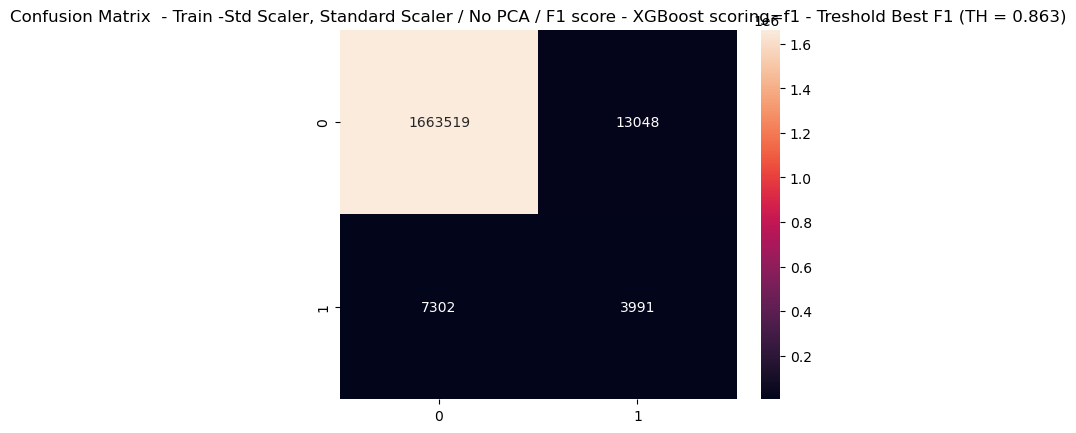

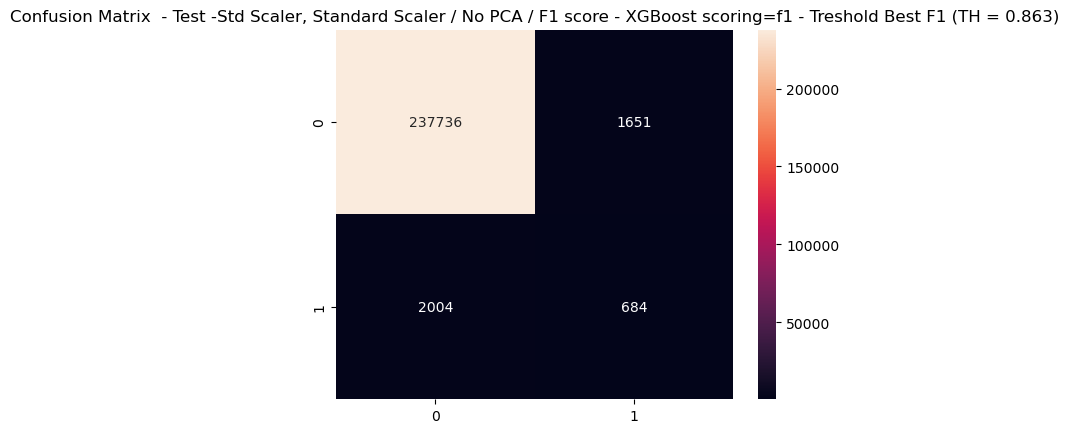



Train - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best F1 (TH = 0.863)
F1-score: 0.2817309049837639 F1-score-micro: 0.9879433128340028 MCC: 0.28185758705864356
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1676567
           1       0.23      0.35      0.28     11293

    accuracy                           0.99   1687860
   macro avg       0.61      0.67      0.64   1687860
weighted avg       0.99      0.99      0.99   1687860


Test - Std Scaler, Standard Scaler / No PCA / F1 score - XGBoost scoring=f1 - Treshold Best F1 (TH = 0.863)
F1-score: 0.2723472028668127 F1-score-micro: 0.9849013735412578 MCC: 0.2654268527781569
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    239387
           1       0.29      0.25      0.27      2688

    accuracy                           0.98    242075
   macro avg       0.64      0.62      0.63    242075
weig

In [8]:
import os
os.environ['JOBLIB_TEMP_FOLDER'] = '~/jupyter_temp'

mcc_scorer = make_scorer(matthews_corrcoef, greater_is_better=True)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    warnings.simplefilter('ignore')
    import logging
    logger = logging.getLogger()
    logger.setLevel(logging.CRITICAL)
    ModelsGridSearch(
        label='Std Scaler, Standard Scaler / No PCA / F1 score',
        scorings=['f1'], # ,'average_precision','mcc'],
        calibrate_classifier=False,
        models_to_test=models_to_test(scaler_strategy=pipeline_functions.CustomScalerType.STANDARD,pca_components=0),
        X_train_=X,
        y_train_=y,
        X_test_=X_test,
        y_test_=y_test
    )


In [9]:
# df_result = pd.DataFrame({'param': grid_search.cv_results_["params"], 'acc': grid_search.cv_results_["mean_test_score"]})
# df_result.to_hdf(output_dir_complete_dataset + 'output_result.h5', 'df', 'w')
# df_result